# Watershed Cell Segmentation Analysis

In [10]:
import numpy as np
from scipy import ndimage
from scipy.ndimage import label, distance_transform_edt
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt
from PIL import Image
import os

## Load and Convert Image to Binary

Image shape: (950, 950)
Otsu threshold: 111
White pixels: 87623


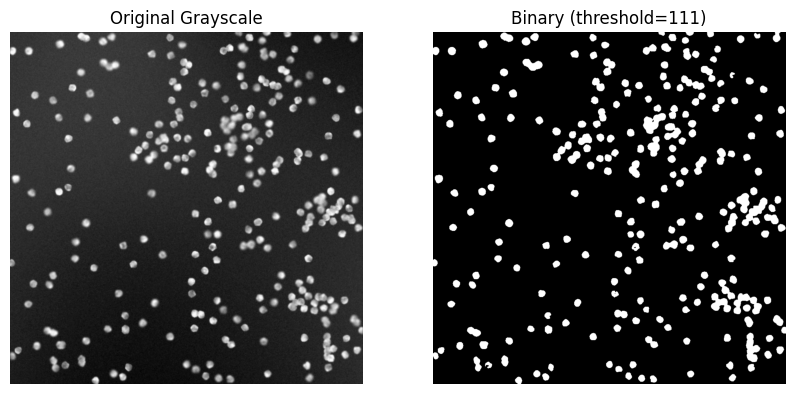

In [11]:
# Configuration
image_path = '../samples/hard/1HARD.bmp'  # Change this to your image
min_distance_values = [4, 5, 6, 7, 8, 9, 10]  # Values to test

# Load image
img = Image.open(image_path).convert('L')
grayscale = np.array(img)

# Apply Otsu thresholding
threshold = threshold_otsu(grayscale)
binary = grayscale > threshold

print(f"Image shape: {grayscale.shape}")
print(f"Otsu threshold: {threshold}")
print(f"White pixels: {np.sum(binary)}")

# Display original and binary
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(grayscale, cmap='gray')
axes[0].set_title('Original Grayscale')
axes[1].imshow(binary, cmap='gray')
axes[1].set_title(f'Binary (threshold={threshold:.0f})')
for ax in axes:
    ax.axis('off')
plt.show()

## Distance Transform Analysis


Max distance: 14.2
Mean distance (non-zero): 3.8


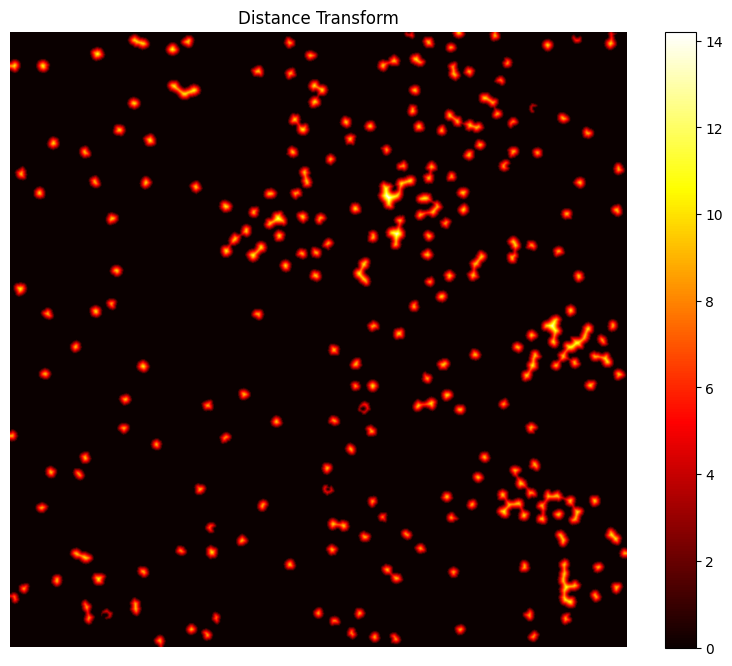

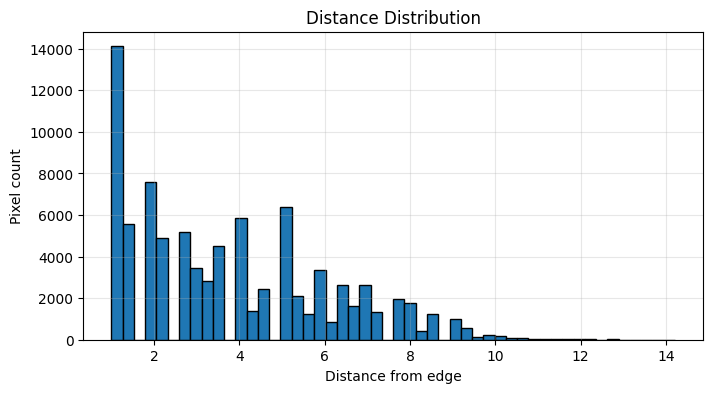

In [12]:
# Compute distance transform
distance = distance_transform_edt(binary)

print(f"Max distance: {distance.max():.1f}")
print(f"Mean distance (non-zero): {distance[binary].mean():.1f}")

# Visualize distance transform
plt.figure(figsize=(10, 8))
im = plt.imshow(distance, cmap='hot')
plt.colorbar(im)
plt.title('Distance Transform')
plt.axis('off')
plt.show()

# Show distance histogram
plt.figure(figsize=(8, 4))
plt.hist(distance[binary].flatten(), bins=50, edgecolor='black')
plt.xlabel('Distance from edge')
plt.ylabel('Pixel count')
plt.title('Distance Distribution')
plt.grid(True, alpha=0.3)
plt.show()

## Test Different min_distance Parameters

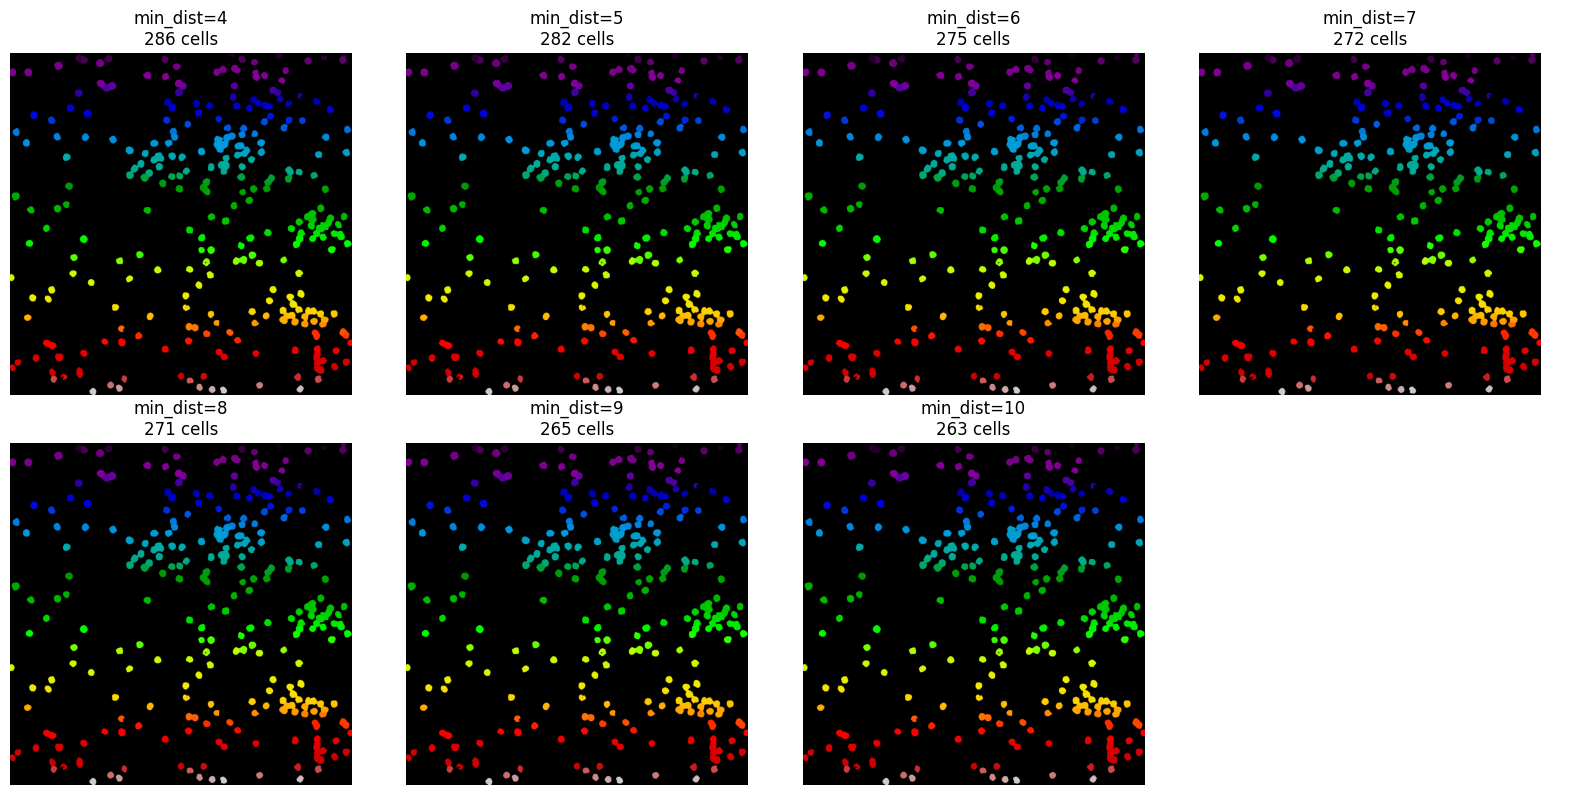


Results Summary:
------------------------------
min_distance= 4: 286 cells
min_distance= 5: 282 cells
min_distance= 6: 275 cells
min_distance= 7: 272 cells
min_distance= 8: 271 cells
min_distance= 9: 265 cells
min_distance=10: 263 cells


In [13]:
from skimage.feature import peak_local_max
from skimage.morphology import local_maxima, disk

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

results = {}

for i, min_dist in enumerate(min_distance_values):
    # Find peaks - correct API
    coords = peak_local_max(
        distance, 
        min_distance=min_dist,
        exclude_border=False
    )
    
    # Convert coordinates to mask
    local_maxima_mask = np.zeros_like(distance, dtype=bool)
    local_maxima_mask[coords[:, 0], coords[:, 1]] = True
    
    # Label peaks
    markers, num_peaks = label(local_maxima_mask)
    
    # Watershed
    labels = watershed(-distance, markers, mask=binary)
    
    # Store results
    results[min_dist] = {
        'num_peaks': num_peaks,
        'labels': labels
    }
    
    # Display
    if i < 8:
        axes[i].imshow(labels, cmap='nipy_spectral')
        axes[i].set_title(f'min_dist={min_dist}\n{num_peaks} cells')
        axes[i].axis('off')

# Hide unused axes
for i in range(len(min_distance_values), 8):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Print summary
print("\nResults Summary:")
print("-" * 30)
for dist, res in results.items():
    print(f"min_distance={dist:2d}: {res['num_peaks']:3d} cells")

## Detailed Analysis of Best Parameter


In [ ]:
# Select best min_distance (adjust based on your results)
best_min_distance = 7  # Adjust this based on expected cell count

# Recompute with best parameter
local_maxima = peak_local_max(
    distance, 
    min_distance=best_min_distance,
    exclude_border=False
)

markers, num_peaks = label(local_maxima)
labels = watershed(-distance, markers, mask=binary)

# Create watershed lines
watershed_lines = np.zeros_like(binary)
for i in range(1, labels.max() + 1):
    mask = labels == i
    dilated = ndimage.binary_dilation(mask)
    border = dilated & ~mask
    watershed_lines |= border

# Apply erosion
result = binary.copy()
result[watershed_lines] = False

# Visualize final result
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(binary, cmap='gray')
axes[0, 0].set_title('Binary Image')

axes[0, 1].imshow(local_maxima, cmap='gray')
axes[0, 1].set_title(f'Cell Centers ({num_peaks})')

axes[0, 2].imshow(labels, cmap='nipy_spectral')
axes[0, 2].set_title('Watershed Regions')

axes[1, 0].imshow(watershed_lines, cmap='gray')
axes[1, 0].set_title('Watershed Lines')

axes[1, 1].imshow(result, cmap='gray')
axes[1, 1].set_title('After Erosion')

# Create overlay
overlay = np.stack([binary, binary, binary], axis=-1).astype(float)
overlay[watershed_lines, 0] = 1  # Red lines
overlay[watershed_lines, 1] = 0
overlay[watershed_lines, 2] = 0
axes[1, 2].imshow(overlay)
axes[1, 2].set_title('Overlay')

for ax in axes.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()

print(f"\nFinal result with min_distance={best_min_distance}:")
print(f"Number of cells detected: {num_peaks}")

TypeError: peak_local_max() got an unexpected keyword argument 'indices'

## Export Results

In [ ]:
Image.fromarray((binary * 255).astype(np.uint8)).save('binary.bmp')
Image.fromarray((result * 255).astype(np.uint8)).save('watershed_result.bmp')
print("Saved: binary.bmp and watershed_result.bmp")